In [141]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import sys
sys.path.append("..")
from LeastSquare import LeastSquare as LS
from LinearRegression import LinearRegression as LR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2"))
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 3})

# function Sin

In [96]:
sin = lambda x: np.sin(np.pi*x)

n_res = 10000
x = np.linspace(-1, 1, n_res)
y = sin(x)
noise = np.random.randn(n_res)/5
y_noise = y + noise

## Random Sample ranint = Discrete Uniform

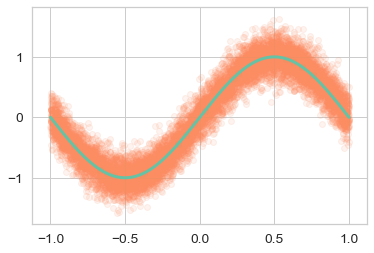

In [97]:
sample_size = 20
sample_ind = np.random.randint(0, n_res, sample_size)

plt.scatter(np.take(x, sample_ind), np.take(y, sample_ind))
plt.plot(x, y)
plt.scatter(x, y_noise, alpha=0.1)



# fold array and roll array for cross validation

In [98]:
def fold_arr(arr, num_fold):
    """
        fold numpy arr as num_fold
        for cross validation
    """
    fold_list = []
    fold_size = int(len(arr)/num_fold)
    for i in range(num_fold):
        if i == num_fold - 1:
            s  = arr[i*fold_size:]
        else:
            s  = arr[i*fold_size:(i+1)*fold_size]
        fold_list.append(s)
    return np.array(fold_list)

def roll_fold(arr):
    rolled = np.roll(arr, 1, axis=0)
    return rolled


# MSE

In [99]:
def mse(x, y):
    mse = np.mean((x-y)**2)
    return mse

In [100]:
def create_degree_x(raw_x, degree):
    new_x = []
    for w in raw_x:
        xx = []
        for i in range(degree+1):
            xx.append(w**i)
        new_x.append(xx)
    return np.array(new_x)

In [142]:
def train_folds(x_fold, y_fold, degree):
    
    fold_w = []
    fold_test_err = []
    fold_train_err = []
    
    for i in range(len(x_fold)):
        x_train = x_fold[:-1].flatten()
        y_train = y_fold[:-1].flatten()
        x_test = x_fold[-1].flatten()
        y_test = x_fold[-1].flatten()
        
        x_train_poly = create_degree_x(x_train, degree)
        x_test_poly = create_degree_x(x_test, degree)
        
        polynomial_features= PolynomialFeatures(degree=degree)
        x_train_poly = polynomial_features.fit_transform(x_train[:, np.newaxis])
        x_test_poly = polynomial_features.fit_transform(x_test[:, np.newaxis])
        model = LinearRegression()
        model.fit(x_train_poly, y_train[:, np.newaxis])
        w = model.coef_[0]

        fold_w.append(w)

        
        train_err = mse(x_train_poly.dot(w.T), y_train)
        test_err = mse(x_test_poly.dot(w.T), y_test)
        fold_train_err.append(train_err)
        fold_test_err.append(test_err)
        
        x_fold = roll_fold(x_fold)
        y_fold = roll_fold(y_fold)
    
    fold_w = np.round(np.array(fold_w), 4)
    fold_test_err = np.round(np.array(fold_test_err), 4)
    fold_train_err = np.round(np.array(fold_train_err), 4)
    return fold_w, fold_test_err, fold_train_err

# funtion สำหรับ train/test fold วนจนกว่าจะครบทุก fold

In [ ]:
degree_list = list(range(0, 10))
repeat = 10

repeat_test_errors = []
repeat_train_errors = []
repeat_out_errors = []
repeat_w = []

for r in range(repeat):
    # list ของ test/train error ตาม แต่ละ degree, มี 10 fold error
    # error of degree i = [fold-1-e, fold-2-e, ... fold-n-e]
    test_errors = []
    train_errors = []
    # out of sample error จาก model เฉลี่ย
    out_errors = []
    weights = []
    
    num_fold = 10
    sample_size = 10
    
    sample_ind = np.random.randint(0, n_res, sample_size)
    x_sample = np.take(x, sample_ind)
    y_sample = np.take(y_noise, sample_ind)

    x_fold = fold_arr(x_sample, num_fold)
    y_fold = fold_arr(y_sample, num_fold)

    print(f'round: {r}')
    
    fig = plt.figure(figsize=(9, 5))
    sns.scatterplot(x_sample, y_sample)
    for degree in degree_list:
        w, test_err, train_err = train_folds(x_fold, y_fold, degree)
        w = np.mean(w, axis=0)
        x_aug = create_degree_x(x, degree)
        y_model = x_aug.dot(w.T)
        out_err = mse(y_model, y_noise)

        test_errors.append(test_err)
        train_errors.append(train_err)
        out_errors.append(out_err)
        sns.lineplot(x, y_model, label=f'degree {degree}', alpha=0.5)
        weights.append(w)
        
    repeat_test_errors.append(test_errors)   
    repeat_train_errors.append(train_errors)
    repeat_out_errors.append(out_errors)
    repeat_w.append(w)
    

round: 0
round: 1
round: 2
round: 3
round: 4


In [ ]:
repeat_out_errors = np.array(repeat_out_errors)
repeat_test_errors = np.array(repeat_test_errors)
repeat_train_errors = np.array(repeat_train_errors)

print(repeat_test_errors.shape)
print(repeat_train_errors.shape)

In [ ]:
plt.plot(degree_list, out_errors)

In [ ]:
fig = plt.figure(figsize=(10, 5))
mean_test_err = np.mean(repeat_test_errors, axis=0).T
num_fold = len(mean_test_err[0])
print(mean_test_err)
for i in range(num_fold):
    sns.lineplot(degree_list, mean_test_err[i], label=f'fold {i}')

plt.xlabel('degree')
plt.ylabel('test error')

In [ ]:
fig = plt.figure(figsize=(10, 5))
mean_train_errors = np.mean(repeat_train_errors, axis=0).T
print(mean_train_errors)
num_fold = len(mean_train_errors[0])

for i in range(num_fold):
    sns.lineplot(degree_list, mean_train_errors[i], label=f'fold {i}')

plt.xlabel('degree')
plt.ylabel('train error')